<a href="https://colab.research.google.com/github/manasamorthad/Machine-Learning/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
print("=== LOADING BREAST CANCER WISCONSIN DATASET ===")
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names
target_names = data.target_names

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Number of samples: {X.shape[0]}")
print(f"Feature names: {feature_names}")
print(f"Target names: {target_names}")
print(f"Target distribution: {np.bincount(y)}")
print(f"  - {target_names[0]}: {np.sum(y == 0)} samples")
print(f"  - {target_names[1]}: {np.sum(y == 1)} samples")

=== LOADING BREAST CANCER WISCONSIN DATASET ===
Dataset shape: (569, 30)
Number of features: 30
Number of samples: 569
Feature names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
Target names: ['malignant' 'benign']
Target distribution: [212 357]
  - malignant: 212 samples
  - benign: 357 samples


In [ ]:
# Create DataFrame for better visualization
print("\n=== DATA CLEANING AND PREPROCESSING ===")
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df['diagnosis'] = df['target'].map({0: 'malignant', 1: 'benign'})

# Check for missing values
print("\n1. Checking for missing values:")
print(df.isnull().sum())

# Check for duplicates
print(f"\n2. Number of duplicate rows: {df.duplicated().sum()}")

# Check data types
print("\n3. Data types:")
print(df.dtypes)

# Check for infinite values
print(f"\n4. Infinite values in features: {np.any(np.isinf(X))}")

# Basic statistics
print("\n5. Basic statistics:")
print(df.describe())

# Remove duplicates if any
if df.duplicated().sum() > 0:
    df = df.drop_duplicates()
    print(f"Removed {df.duplicated().sum()} duplicates")

# Update X and y after cleaning
X_clean = df.drop(['target', 'diagnosis'], axis=1).values
y_clean = df['target'].values

print(f"\nShape after cleaning: {X_clean.shape}")


=== DATA CLEANING AND PREPROCESSING ===

1. Checking for missing values:
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
diagnosis                  


=== EXPLORATORY DATA ANALYSIS ===


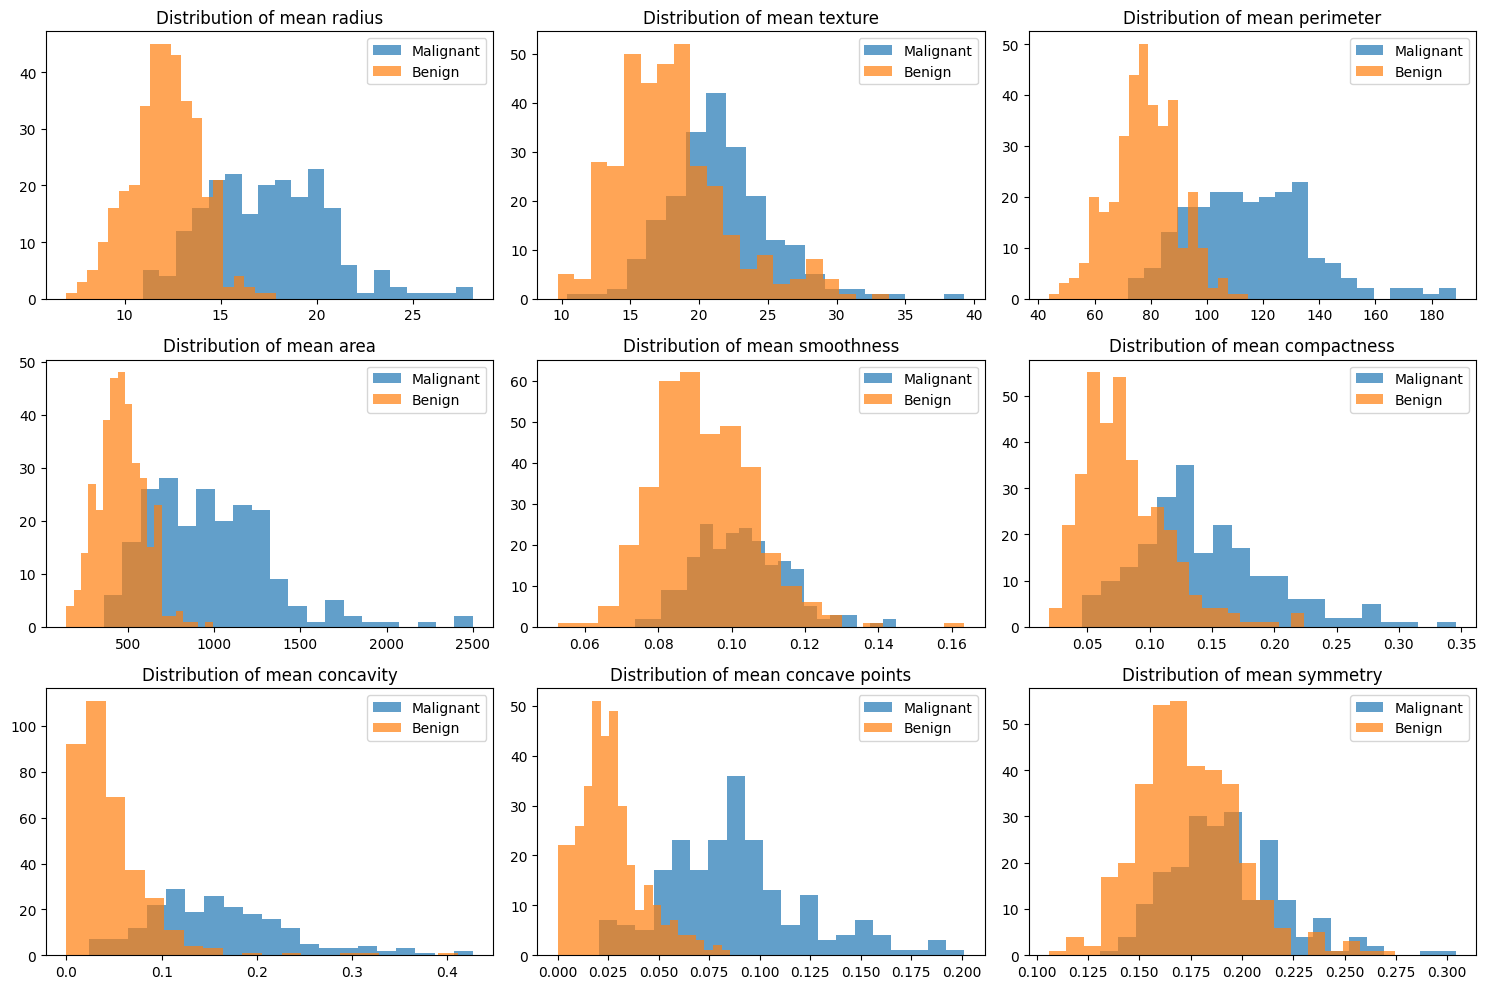

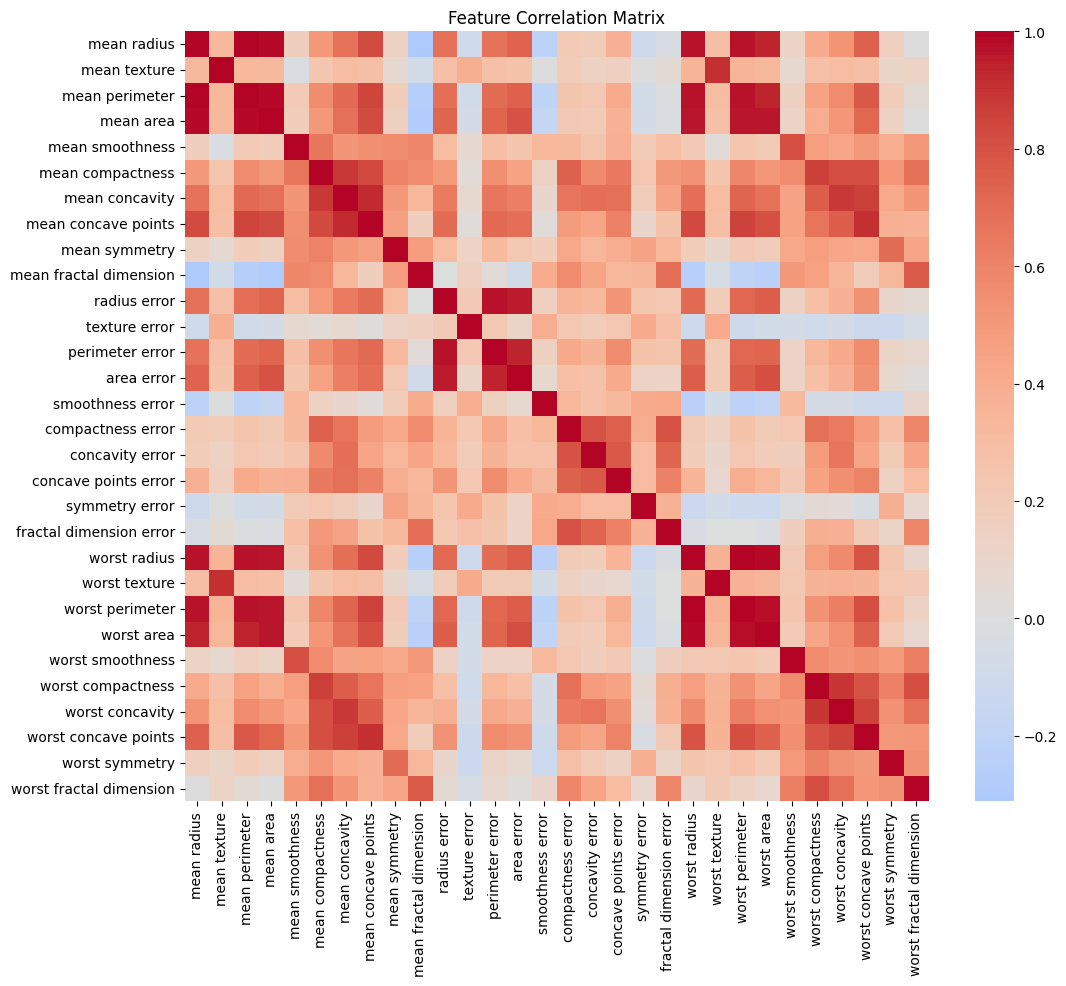

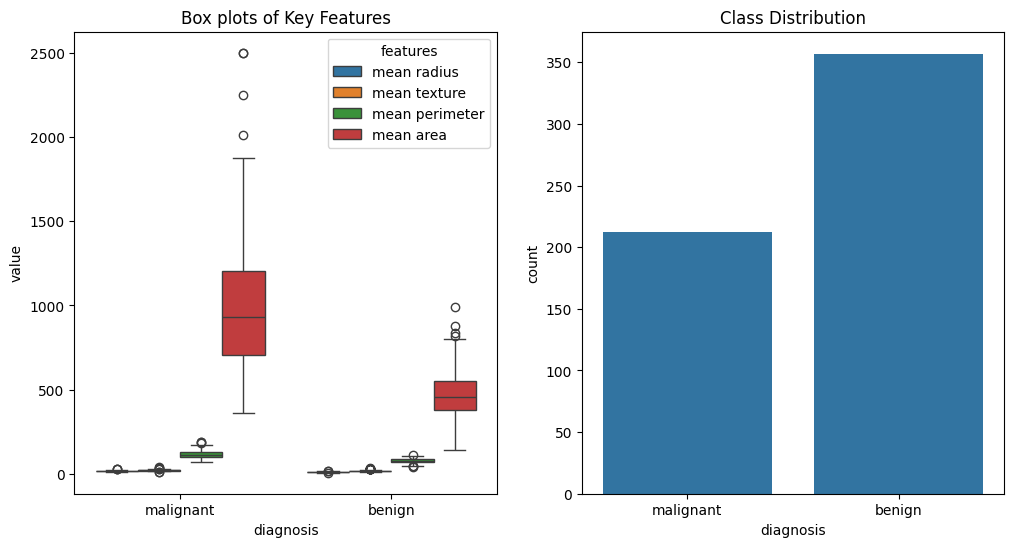


Key observations from EDA:
- Features show clear separation between malignant and benign cases
- Some features are highly correlated (e.g., radius, perimeter, area)
- Dataset is balanced enough for SVM without needing resampling


In [ ]:
print("\n=== EXPLORATORY DATA ANALYSIS ===")

# 1. Feature distributions
plt.figure(figsize=(15, 10))

# Plot first 9 features distributions by diagnosis
for i in range(9):
    plt.subplot(3, 3, i+1)
    feature = feature_names[i]
    plt.hist(df[df['diagnosis'] == 'malignant'][feature], alpha=0.7, label='Malignant', bins=20)
    plt.hist(df[df['diagnosis'] == 'benign'][feature], alpha=0.7, label='Benign', bins=20)
    plt.title(f'Distribution of {feature}')
    plt.legend()

plt.tight_layout()
plt.show()

# 2. Correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df.drop(['target', 'diagnosis'], axis=1).corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# 3. Box plots for key features
plt.figure(figsize=(12, 6))
selected_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area']
df_melted = pd.melt(df, id_vars=['diagnosis'], value_vars=selected_features,
                   var_name='features', value_name='value')

plt.subplot(1, 2, 1)
sns.boxplot(x='diagnosis', y='value', hue='features', data=df_melted)
plt.title('Box plots of Key Features')

# 4. Class distribution
plt.subplot(1, 2, 2)
sns.countplot(x='diagnosis', data=df)
plt.title('Class Distribution')
plt.show()

print("\nKey observations from EDA:")
print("- Features show clear separation between malignant and benign cases")
print("- Some features are highly correlated (e.g., radius, perimeter, area)")
print("- Dataset is balanced enough for SVM without needing resampling")

In [ ]:
print("\n=== DATA SPLITTING AND SCALING ===")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

# Scale the features (CRUCIAL for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature scaling completed using StandardScaler")
print("Mean of scaled training features:", np.mean(X_train_scaled, axis=0)[:5])
print("Std of scaled training features:", np.std(X_train_scaled, axis=0)[:5])


=== DATA SPLITTING AND SCALING ===
Training set size: 455
Test set size: 114
Training set class distribution: [170 285]
Test set class distribution: [42 72]

Feature scaling completed using StandardScaler
Mean of scaled training features: [-4.31742554e-15  2.24606658e-15 -7.38359313e-16  1.71779562e-16
  5.22695440e-15]
Std of scaled training features: [1. 1. 1. 1. 1.]


In [ ]:
print("\n=== BASELINE SVM MODELS WITH DEFAULT PARAMETERS ===")

# Define kernels to test
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
baseline_results = {}

for kernel in kernels:
    print(f"\n--- Training {kernel.upper()} Kernel SVM ---")

    # Create and train SVM
    svm_model = SVC(kernel=kernel, random_state=42)
    svm_model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = svm_model.predict(X_test_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results
    baseline_results[kernel] = {
        'model': svm_model,
        'accuracy': accuracy,
        'f1_score': f1
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Support vectors: {svm_model.support_vectors_.shape[0]}")

# Display baseline comparison
print("\n=== BASELINE MODEL COMPARISON ===")
baseline_df = pd.DataFrame(baseline_results).T
print(baseline_df[['accuracy', 'f1_score']].round(4))


=== BASELINE SVM MODELS WITH DEFAULT PARAMETERS ===

--- Training LINEAR Kernel SVM ---
Accuracy: 0.9737
F1-Score: 0.9790
Support vectors: 32

--- Training RBF Kernel SVM ---
Accuracy: 0.9825
F1-Score: 0.9861
Support vectors: 97

--- Training POLY Kernel SVM ---
Accuracy: 0.9123
F1-Score: 0.9351
Support vectors: 145

--- Training SIGMOID Kernel SVM ---
Accuracy: 0.9298
F1-Score: 0.9437
Support vectors: 66

=== BASELINE MODEL COMPARISON ===
         accuracy  f1_score
linear   0.973684  0.979021
rbf      0.982456  0.986111
poly     0.912281  0.935065
sigmoid  0.929825  0.943662


In [ ]:
print("\n=== HYPERPARAMETER TUNING WITH GRIDSEARCHCV ===")

# Define parameter grids for all kernels
param_grids = {
    'rbf': {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001, 'scale', 'auto'],
        'kernel': ['rbf']
    },
    'linear': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'kernel': ['linear']
    },
    'poly': {
        'C': [0.1, 1, 10, 100],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto'],
        'coef0': [0.0, 0.5, 1.0],
        'kernel': ['poly']
    },
    'sigmoid': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'coef0': [0.0, 0.1, 0.5],
        'kernel': ['sigmoid']
    }
}

# Perform tuning for all kernels
tuned_models = {}

for kernel_name, param_grid in param_grids.items():
    print(f"\n{kernel_name.upper()} Kernel Tuning...")

    grid = GridSearchCV(
        SVC(random_state=42),
        param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train_scaled, y_train)
    tuned_models[kernel_name] = grid.best_estimator_

    print(f"Best parameters: {grid.best_params_}")
    print(f"Best cross-validation score: {grid.best_score_:.4f}")

print("\n=== COMPREHENSIVE FINAL MODEL EVALUATION ===")

# Collect all models for comparison
all_models = {}

# Add tuned models
for kernel_name, model in tuned_models.items():
    all_models[f"{kernel_name.upper()} (Tuned)"] = model

# Add baseline models from your initial results
for kernel_name, result in baseline_results.items():
    all_models[f"{kernel_name.upper()} (Baseline)"] = result['model']

# Evaluate all models
comprehensive_results = []

for name, model in all_models.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    comprehensive_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'F1-Score': f1
    })

    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")

# Create comprehensive results comparison
comprehensive_df = pd.DataFrame(comprehensive_results)
print("\n=== COMPREHENSIVE COMPARISON ===")
print(comprehensive_df.round(4))

# Sort by F1-Score to see best performing models
print("\n=== MODELS RANKED BY F1-SCORE ===")
ranked_df = comprehensive_df.sort_values('F1-Score', ascending=False)
print(ranked_df.round(4))


=== HYPERPARAMETER TUNING WITH GRIDSEARCHCV ===

RBF Kernel Tuning...
Fitting 5 folds for each of 35 candidates, totalling 175 fits
Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.9844

LINEAR Kernel Tuning...
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters: {'C': 0.1, 'kernel': 'linear'}
Best cross-validation score: 0.9845

POLY Kernel Tuning...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'C': 10, 'coef0': 0.5, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}
Best cross-validation score: 0.9844

SIGMOID Kernel Tuning...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'C': 1, 'coef0': 0.0, 'gamma': 0.01, 'kernel': 'sigmoid'}
Best cross-validation score: 0.9779

=== COMPREHENSIVE FINAL MODEL EVALUATION ===

RBF (Tuned):
  Accuracy: 0.9825
  F1-Score: 0.9861

LINEAR (Tuned):
  Accuracy: 0.9825
  F1-Score: 0.9861

POLY (Tuned):
  Accuracy: 0.9561
  F1-


=== BASELINE vs TUNED MODELS COMPARISON ===


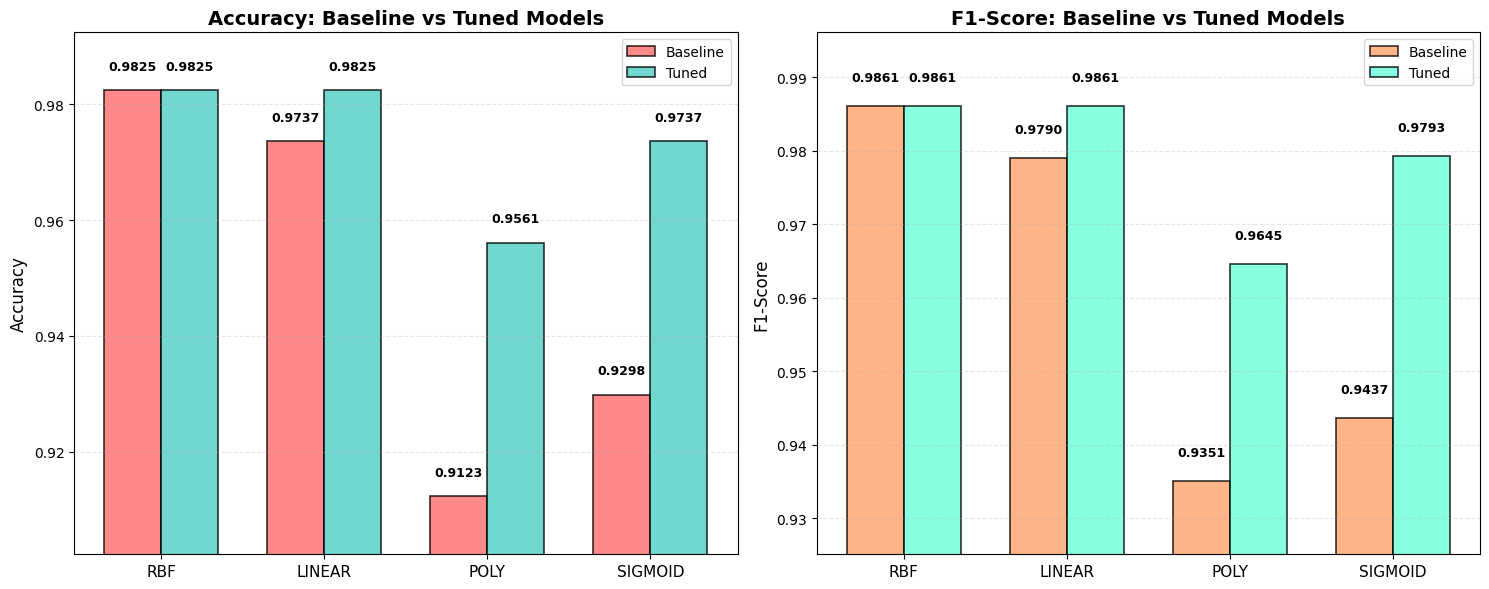


=== PERFORMANCE IMPROVEMENT SUMMARY ===
    Kernel  Accuracy Baseline  Accuracy Tuned  Accuracy Improvement  \
0      RBF             0.9825          0.9825                0.0000   
1   LINEAR             0.9737          0.9825                0.0088   
2     POLY             0.9123          0.9561                0.0439   
3  SIGMOID             0.9298          0.9737                0.0439   

   F1 Baseline  F1 Tuned  F1 Improvement  
0       0.9861    0.9861          0.0000  
1       0.9790    0.9861          0.0071  
2       0.9351    0.9645          0.0295  
3       0.9437    0.9793          0.0356  


In [ ]:
print("\n=== BASELINE vs TUNED MODELS COMPARISON ===")

# Prepare data for side by side comparison
kernel_types = ['RBF', 'LINEAR', 'POLY', 'SIGMOID']
baseline_acc = []
tuned_acc = []
baseline_f1 = []
tuned_f1 = []

for kernel in kernel_types:
    baseline_row = comprehensive_df[comprehensive_df['Model'] == f'{kernel} (Baseline)']
    tuned_row = comprehensive_df[comprehensive_df['Model'] == f'{kernel} (Tuned)']

    baseline_acc.append(baseline_row['Accuracy'].values[0])
    tuned_acc.append(tuned_row['Accuracy'].values[0])
    baseline_f1.append(baseline_row['F1-Score'].values[0])
    tuned_f1.append(tuned_row['F1-Score'].values[0])

# Create side by side comparison plots
plt.figure(figsize=(15, 6))

# Set up the positions for bars
x_pos = np.arange(len(kernel_types))
width = 0.35  # Width of the bars

# 1. Accuracy Comparison
plt.subplot(1, 2, 1)
bars_baseline_acc = plt.bar(x_pos - width/2, baseline_acc, width,
                           label='Baseline', color='#FF6B6B', alpha=0.8,
                           edgecolor='black', linewidth=1.2)
bars_tuned_acc = plt.bar(x_pos + width/2, tuned_acc, width,
                        label='Tuned', color='#4ECDC4', alpha=0.8,
                        edgecolor='black', linewidth=1.2)

plt.title('Accuracy: Baseline vs Tuned Models', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(x_pos, kernel_types, fontsize=11)
plt.ylim(min(baseline_acc + tuned_acc) - 0.01, max(baseline_acc + tuned_acc) + 0.01)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.legend()

# Add value labels on bars
for bar in bars_baseline_acc:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.003,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

for bar in bars_tuned_acc:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.003,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. F1-Score Comparison
plt.subplot(1, 2, 2)
bars_baseline_f1 = plt.bar(x_pos - width/2, baseline_f1, width,
                          label='Baseline', color='#FFA36B', alpha=0.8,
                          edgecolor='black', linewidth=1.2)
bars_tuned_f1 = plt.bar(x_pos + width/2, tuned_f1, width,
                       label='Tuned', color='#6BFFD6', alpha=0.8,
                       edgecolor='black', linewidth=1.2)

plt.title('F1-Score: Baseline vs Tuned Models', fontsize=14, fontweight='bold')
plt.ylabel('F1-Score', fontsize=12)
plt.xticks(x_pos, kernel_types, fontsize=11)
plt.ylim(min(baseline_f1 + tuned_f1) - 0.01, max(baseline_f1 + tuned_f1) + 0.01)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.legend()

# Add value labels on bars
for bar in bars_baseline_f1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.003,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

for bar in bars_tuned_f1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.003,
             f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Print improvement summary
print("\n=== PERFORMANCE IMPROVEMENT SUMMARY ===")
improvement_data = []
for i, kernel in enumerate(kernel_types):
    acc_improvement = tuned_acc[i] - baseline_acc[i]
    f1_improvement = tuned_f1[i] - baseline_f1[i]
    improvement_data.append({
        'Kernel': kernel,
        'Accuracy Baseline': baseline_acc[i],
        'Accuracy Tuned': tuned_acc[i],
        'Accuracy Improvement': acc_improvement,
        'F1 Baseline': baseline_f1[i],
        'F1 Tuned': tuned_f1[i],
        'F1 Improvement': f1_improvement
    })

improvement_df = pd.DataFrame(improvement_data)
print(improvement_df.round(4))